# Machine Learning Midterm Assginment
## 2021021699 이유원

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import copy
import requests
import pickle
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

## **Function for utils**

In [3]:
def data_preprocessing(data):
    """Function for preprocess the data before training

    The preprocess steps are altering the outlier data to the mean value.
    Also, Scaling the data with the scaler that is fitted to the data used to train the model.

    Args:
        data: The dataframe that has col name 'Class Label' and other features

    Returns:
        preprocessed data

    """
    # IQR outlier altering to mean
    label_list = np.unique(data['Class Label'].to_numpy())
    processed_df = []
    for class_num in label_list:
        data_per_class = data.loc[data['Class Label'] == class_num, : ].copy()
        data_pre = data_per_class.loc[:, data_per_class.columns != 'Class Label'].copy()
        data_class = data_per_class.loc[:, data_per_class.columns == 'Class Label'].copy()
            
        for col in data_pre.columns:
            q1 = np.quantile(data_pre[f'{col}'], 0.25)
            q3 = np.quantile(data_pre[f'{col}'], 0.75)
            IQR = q3 - q1
            condition = (data_pre[f'{col}'] < (q1 - 1.5 * IQR)) | (data_pre[f'{col}'] > (q3 + 1.5 * IQR))
            outlier = data_pre[condition]
            data_pre[f'{col}'] = data_pre[f'{col}'].replace([data_pre[f'{col}'][outlier.index]], data_pre[f'{col}'].mean())

        data_trimmed = pd.concat([data_class, data_pre], axis=1)

        processed_df.append(data_trimmed)            
    

    data_pre = pd.concat(processed_df, axis=0)
    
    class_label = data_pre.loc[:, data_pre.columns == 'Class Label']
    data_pre = data_pre.drop(['Class Label'], axis=1)


    # Getting the scaler from github.
    # The scaler is used fitted to the data used to train the model
    sLink = 'https://github.com/2U1/ML_RDACOV/blob/master/scaler.pkl?raw=True'
    sFile = BytesIO(requests.get(sLink).content)
    scaler = pickle.load(sFile)
    data_scaled = scaler.transform(data_pre)
    data_scaled = pd.DataFrame(data=data_scaled, columns=data_pre.columns)

    data_processed = pd.concat([class_label, data_scaled], axis=1)

    return data_processed

In [4]:
def get_clf_eval(y_test, pred):
    """The fucntion for getting the evaluation scores.

    It prints accuracy score, recall, precision, f1-score.

    Args:
        y_test: The label from the test dataset
        pred: The list label that the model has predicted with the test dataset
    """
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    print('Accuracy:{0:.4f}, Recall:{1:.4f}, Precision:{2:.4f}, F1-Score:{3:.4f}'.format(accuracy, recall, precision, f1))

In [5]:
def make_confusion(y_test, y_pred):
    """ The function for making the 3-class confusion matrix.

    Args:
        y_test: The label from the test dataset.
        pred: The list label that the model has predicted with the test dataset.

    Returns:
        The 3-class confusion matrix made with dataframe.
    """
    confusion = confusion_matrix(y_test,y_pred)
    confusion_df = pd.DataFrame(confusion,columns=['Predicted_1','Predicted_2', 'Predicted_3'],index=['Predicted_1','Predicted_2', 'Predicted_3'])
    
    return confusion_df

In [6]:
def load_dataset(directory, preprocess = False):
    """The function for loading the dataset
    
    It loads the data and dosen't return and put the data in to global variables.

    Args:
        directory: The directory that the dataset is located
        preprocess: boolean for preprocessing, the default value is False
    """
    global  data, x, y

    data = pd.read_csv(directory)
    
    if preprocess:
        data = data_preprocessing(data)

    y = data['Class Label'].to_numpy()
    x = data.loc[:, data.columns != 'Class Label'].to_numpy()

## **Class that operates RDA**

RDA is a compromise of convariance of LDA($\hat{\Sigma}$)  and QDA($\hat{\Sigma_k}$)
By using tuning parameter $\alpha$ and $\beta$.<br>
$\hat{\Sigma_k}(\beta) = (1-\beta)\hat{\Sigma_k} + \beta\hat{\Sigma}$<br>
$\hat{\Sigma_k}(\alpha, \beta)$ = $(1-\alpha)\hat{\Sigma_k}(\beta)+\alpha\frac{1}{p}tr(\hat{\Sigma_k(\beta)})I$

In [7]:
class DiscriminentAnalysis():
    """Class for executing RDA
    
    alpha=beta=0: quadric classifier
    alpha=0 and beta=1: shared covariance, linear classifier
    alpha=1 and beta =0: diagonal covariance, nearest mean classifier
    
    In Between theses extreme cases optimizing alpha and beta 
    
    Usage example:
    dis = DiscriminentAnalysis(alpha=0.5, beta=0.7, eval_mode = False)
    dis.fit(train_x, train_y)
    dis.predict(test_x[0])
    """
    def __init__(self, alpha=0.0, beta=0.0, eval_mode = False):
        """
        Args:
            alpha: Tuning parameter alpha
            beta: Tuning parameter beta
            eval_mode: boolean for choosing the evaluation mode or training mode
        Attributes:
            learned: Keeps track of if RDA has been fit
            alpha: Regularization parameter in range [0, 1]
            beta: Regularization parameter in range [0, 1]
            class_names: Array of class names. [0, 1] for example.
            class_priors: Prior probability of each class.
            class_means: Vector means of each class
            regularized_covariances: Regulized covariances to calculate RDA covariance.
            rda_covariance: RDA covariance
            feature_dimension: The dimension of the feature data
        """
        if not eval_mode:
            self.learned = False
            self.alpha = alpha
            self.beta = beta
            self.class_names = []
            self.class_priors = {}
            self.class_means = {}
            self.regularized_covariances = {}
            self.rda_covariances = {}
            self.feature_dimension = 0
            self.reset()

        else:
            self.load_parameter()


    def load_parameter(self):
        """Loading the trained parameter from github."""
        
        mLink = 'https://github.com/2U1/ML_RDACOV/blob/master/parameter.pkl?raw=true'
        mfile = BytesIO(requests.get(mLink).content)
        parameter = pickle.load(mfile)
        

        self.learned = True
        self.alpha = parameter['alpha']
        self.beta = parameter['beta']
        self.class_names = parameter['class_name']
        self.class_priors = parameter['class_priors']
        self.class_means = parameter['class_means']
        self.regularized_covariances = parameter['reg_cov']
        self.rda_covariances = parameter['rda_cov']


    def reset(self):
        """Resetting the parametes to initalized state."""
        self.learned = False
        self.class_names = []
        self.class_priors = {}
        self.class_means = {}
        self.regularized_covariances = {}
        self.rda_covariances = {}


    def return_parameters(self):
        """Return the calculated paremters of the model"""
        parameters = {
            'alpha': self.alpha,
            'beta': self.beta,
            'class_name': self.class_names,
            'class_priors': self.class_priors,
            'class_means': self.class_means,
            'reg_cov': self.regularized_covariances,
            'rda_cov': self.rda_covariances
        }

        return parameters

    def fit(self, X, y):
        """Training function. Calculates the rda covariance.

        Changes the value of self.learned, so can use the predict function.
        
        Args:
            X: The feature of the dataset.
            y: The class of the dataset.

        Returns:
            Self: The updated values of the model.
        """
        self.class_names = np.unique(y)
        class_covariances = {}
        pooled_covariances = 0
        self.feature_dimension = X.shape[1]
        for i in self.class_names:
            class_indices = np.where(y == i)[0]
            class_samples = X[class_indices, :]
            self.class_priors[i] = float(len(class_indices)) / len(y)
            self.class_means[i] = np.mean(class_samples, axis=0)
            class_covariances[i] = np.cov(class_samples, rowvar=0)
            pooled_covariances += class_covariances[i] * self.class_priors[i]
        # Calculate regularized covariance matricies for each class
        for i in self.class_names:
            self.regularized_covariances[i] = (self.beta * pooled_covariances) + ((1 - self.beta) *class_covariances[i])

        # Calulate the RDA covarinace matriceis for each class
        for i in self.class_names:
            self.rda_covariances[i] = ((1-self.alpha) * self.regularized_covariances[i]) + (self.alpha * (1/self.feature_dimension) * np.trace(self.regularized_covariances[i]) * np.eye(self.regularized_covariances[i].shape[0]))
        
        # Changing the value to use the predict function
        self.learned = True
        return self

    def predict(self, x):
        """Predicting the class of the data

        Calculate the problems for each class and return the maximum value for the classes and return the class name

        Args:
            x: feature data to predict class

        Returns:
            Class name of the maximum probablitiy 
        """
        if not self.learned:
            raise NameError('Fit model first')
        # Determine probability of each class given input vector
        
        class_prob = {}
        for i in self.class_names:
            # Divid the class delta calculation into 3 parts
            part1 = -0.5 * np.log1p(np.linalg.det(self.rda_covariances[i]))
            part2 = -0.5 * np.matmul(np.matmul((x - self.class_means[i]).T, np.linalg.pinv(self.rda_covariances[i])), (x - self.class_means[i]))
            part3 = np.log(self.class_priors[i])
            class_prob[i] = part1 + part2 + part3
        return max(class_prob, key=class_prob.get)

## **Class for operating GridSearch that finds the optimal $\alpha$ and $\beta$**

In [75]:
class GridSearchRDA():
    """Class for Gridsearch


    Finding the optimal alhpa and beta for the RDA model, and save the calculated parameters and the model itself.

    Args:
        param_grid: Dictionary type that contains the list of hyper parameters to calculate

    Usage example:

        model = DiscriminentAnalysis()
        params = {
                    'alpha': np.linspace(0.0, 1.0, num=11, endpoint=True),
                    'beta': np.linspace(0.0, 1.0, num=11, endpoint=True)
                }
        grid = GridSearchRDA(model, params)
        grid.fit(x,y)

    """
    def __init__(self, model, param_grid):
        """
        Args:
            model: The RDA model to train.
            param_grid: The list of paramters in the dictionary.
        Attributes:
            model: The RDA model to train.
            param_grid: The list of paramters in the dictionary.
            alpha: Tuning parameter alpha
            beta: Tuning parameter alpha
            best_covaraince: Covariances when the model gets highest f1-score
            best_score: The best f1-score
        """
        self.model = model
        self.param_grid = param_grid
        self.alpha = 0
        self.beta = 0
        self.best_covariance = {}
        self.best_score = 0


    def fit(self, X, y, cv=2):
        """ The Training function using cross validation

        Using K-fold the function rotate from the list of alpha and beta to find the best combination.
        
        Args:
            X: the feature data
            y: class label
            cv: The number of folds for K-fold

        """

        data_length = len(X)
        
        alpha_list = self.param_grid['alpha']
        beta_list = self.param_grid['beta']
        
        if data_length % cv == 0:
            cv_x = np.split(X, cv)
            cv_y = np.split(y, cv)
            
        else:
            remain = data_length % cv
            cv_x = np.split(X[:-remain], cv)
            cv_y = np.split(y[:-remain], cv)

        for alpha in alpha_list:
            for beta in beta_list:
                accuracy_score_list = []
                recall_score_list = []
                precision_score_list = []
                f1_score_list = []
                for i in range(cv):
                    self.model.reset()
                    self.model.alpha = alpha
                    self.model.beta = beta

                    test_x_cv = cv_x[i]
                    train_x_cv = np.vstack(cv_x[:i] + cv_x[i + 1:])

                    test_y_cv = cv_y[i]
                    train_y_cv = np.vstack(cv_y[:i] + cv_y[i + 1:]).flatten()

                    
                    self.model.fit(train_x_cv, train_y_cv)

                    pred = []

                    for data in test_x_cv:
                        pred.append(self.model.predict(data))
                    
                    accuracy_score_list.append(accuracy_score(test_y_cv, pred))
                    recall_score_list.append(recall_score(test_y_cv, pred, average='macro'))
                    precision_score_list.append(precision_score(test_y_cv, pred, average='macro', zero_division=1))
                    f1_score_list.append(f1_score(test_y_cv, pred, average='macro'))
                
                accuracy_mean_score = np.mean(np.array(accuracy_score_list))
                recall_mean_score = np.mean(np.array(recall_score_list))
                precision_mean_score = np.mean(np.array(precision_score_list))
                f1_mean_score = np.mean(np.array(f1_score_list))

                print("alpha:{0:.1f}, beta:{1:.1f}, accuracy:{2:.4f}, recall:{3:.4f}, precision:{4:.4f} ,f1-score:{5:.4f}"\
                    .format(alpha, beta, accuracy_mean_score ,recall_mean_score ,precision_mean_score ,f1_mean_score))

                if f1_mean_score > self.best_score:
                    self.best_score = f1_mean_score
                    self.alpha = alpha
                    self.beta = beta
                    self.best_covariance = copy.deepcopy(self.model.rda_covariances)
                    self.best_estimator = copy.deepcopy(self.model)

## **Function for evaluation using the trained parameter**

In [9]:
def test_evaluation(test_x, test_y):
    """Evaluating function from saved parameter

    It prints the metric scores and confusion matrix
    
    Args:
        test_x: The list of feature data
        test_y: The list of class label
    """

    model = DiscriminentAnalysis(eval_mode=True)


    prediction = []
    
    for testing in test_x:
        prediction.append(model.predict(testing))


    confusion = make_confusion(test_y, prediction)
    
    get_clf_eval(test_y, prediction)
    print('\n\n')
    print(confusion)

## Step1 : EDA

In [32]:
load_dataset('./facial_expression_train_dataset.csv')
features = data.loc[:, data.columns != 'Class Label']

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Class Label  87 non-null     int64  
 1   Feature 1    87 non-null     float64
 2   Feature 2    87 non-null     float64
 3   Feature 3    87 non-null     float64
 4   Feature 4    87 non-null     float64
 5   Feature 5    87 non-null     float64
 6   Feature 6    87 non-null     float64
 7   Feature 7    87 non-null     float64
 8   Feature 8    87 non-null     float64
 9   Feature 9    87 non-null     float64
 10  Feature 10   87 non-null     float64
 11  Feature 11   87 non-null     float64
 12  Feature 12   87 non-null     float64
 13  Feature 13   87 non-null     float64
 14  Feature 14   87 non-null     float64
 15  Feature 15   87 non-null     float64
 16  Feature 16   87 non-null     float64
 17  Feature 17   87 non-null     float64
 18  Feature 18   87 non-null     float64
 19  Feature 19

We can see the data has 22 columns of features and one column of class label.

In [17]:
data.describe()

,Class Label,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22
count,87.00000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,...,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,2.00000,8.483087,10.247121,10.274905,10.636085,5.605470,4.713333,5.513524,5.141545,4.906726,...,7.738580,7.626924,13.161087,17.266584,20.520015,17.246136,13.738169,9.934930,8.759992,10.173441
std,0.82123,6.938463,7.531868,7.968037,8.441328,3.660518,3.658772,3.912258,3.527501,4.012182,...,4.428974,4.797308,7.096800,12.710225,18.933429,13.425790,6.836856,5.156688,4.514630,5.129261
min,1.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.414200,0.000000,0.000000,2.000000,4.123100,1.414200,1.000000,2.000000
25%,1.00000,3.605600,4.736050,5.000000,4.736050,3.000000,2.236100,3.162300,3.000000,2.236100,...,4.357350,3.162300,7.615800,8.543800,7.440650,8.573150,7.839050,6.082800,5.099000,5.956900
50%,2.00000,7.071100,7.810200,8.062300,7.615800,5.000000,4.123100,5.000000,4.242600,4.123100,...,7.071100,7.071100,12.165500,13.601500,12.165500,11.704700,12.206600,9.219500,7.810200,9.486800
75%,3.00000,12.041600,14.229950,13.379050,15.264300,7.071100,5.385200,6.708200,6.082800,5.521050,...,10.408350,9.667850,15.967950,21.861450,28.547750,21.628100,19.170200,13.800750,12.287950,14.017250
max,3.00000,35.128300,36.013900,40.162200,40.025000,18.439100,18.439100,20.396100,19.924900,19.646900,...,18.439100,20.248500,30.265500,53.084800,64.124900,51.088200,29.000000,20.591300,21.587000,21.587000


The distribution of features similar to each other but, looking at the max values of each features we could think some features can have outliers.

In [20]:
data.groupby(data['Class Label']).size()

Class Label
1    29
2    29
3    29
dtype: int64

Data has equal numbers of each class 1,2,3

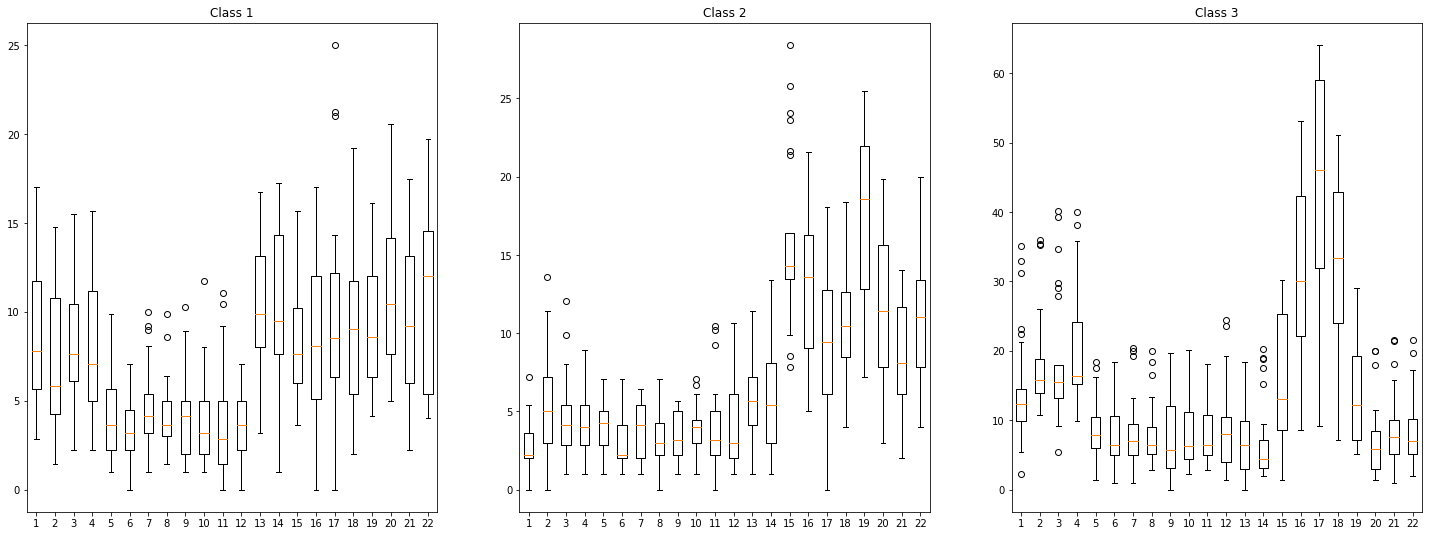

In [66]:
data1 = data[data['Class Label'] == 1].loc[:, data.columns != "Class Label"]
data2 = data[data['Class Label'] == 2].loc[:, data.columns != "Class Label"]
data3 = data[data['Class Label'] == 3].loc[:, data.columns != "Class Label"]


fig = plt.figure(figsize=(25,9))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.boxplot(data1)
ax1.set_title("Class 1")

ax2.boxplot(data2)
ax2.set_title("Class 2")

ax3.boxplot(data3)
ax3.set_title("Class 3")

plt.show()

Plotting the data to boxplot, as we expected above there are someoutliers in the data. Each class has outliers. Before training the model, the outlier has to be removed. I choosed the idea to alter the outlier to the mean of the feature.

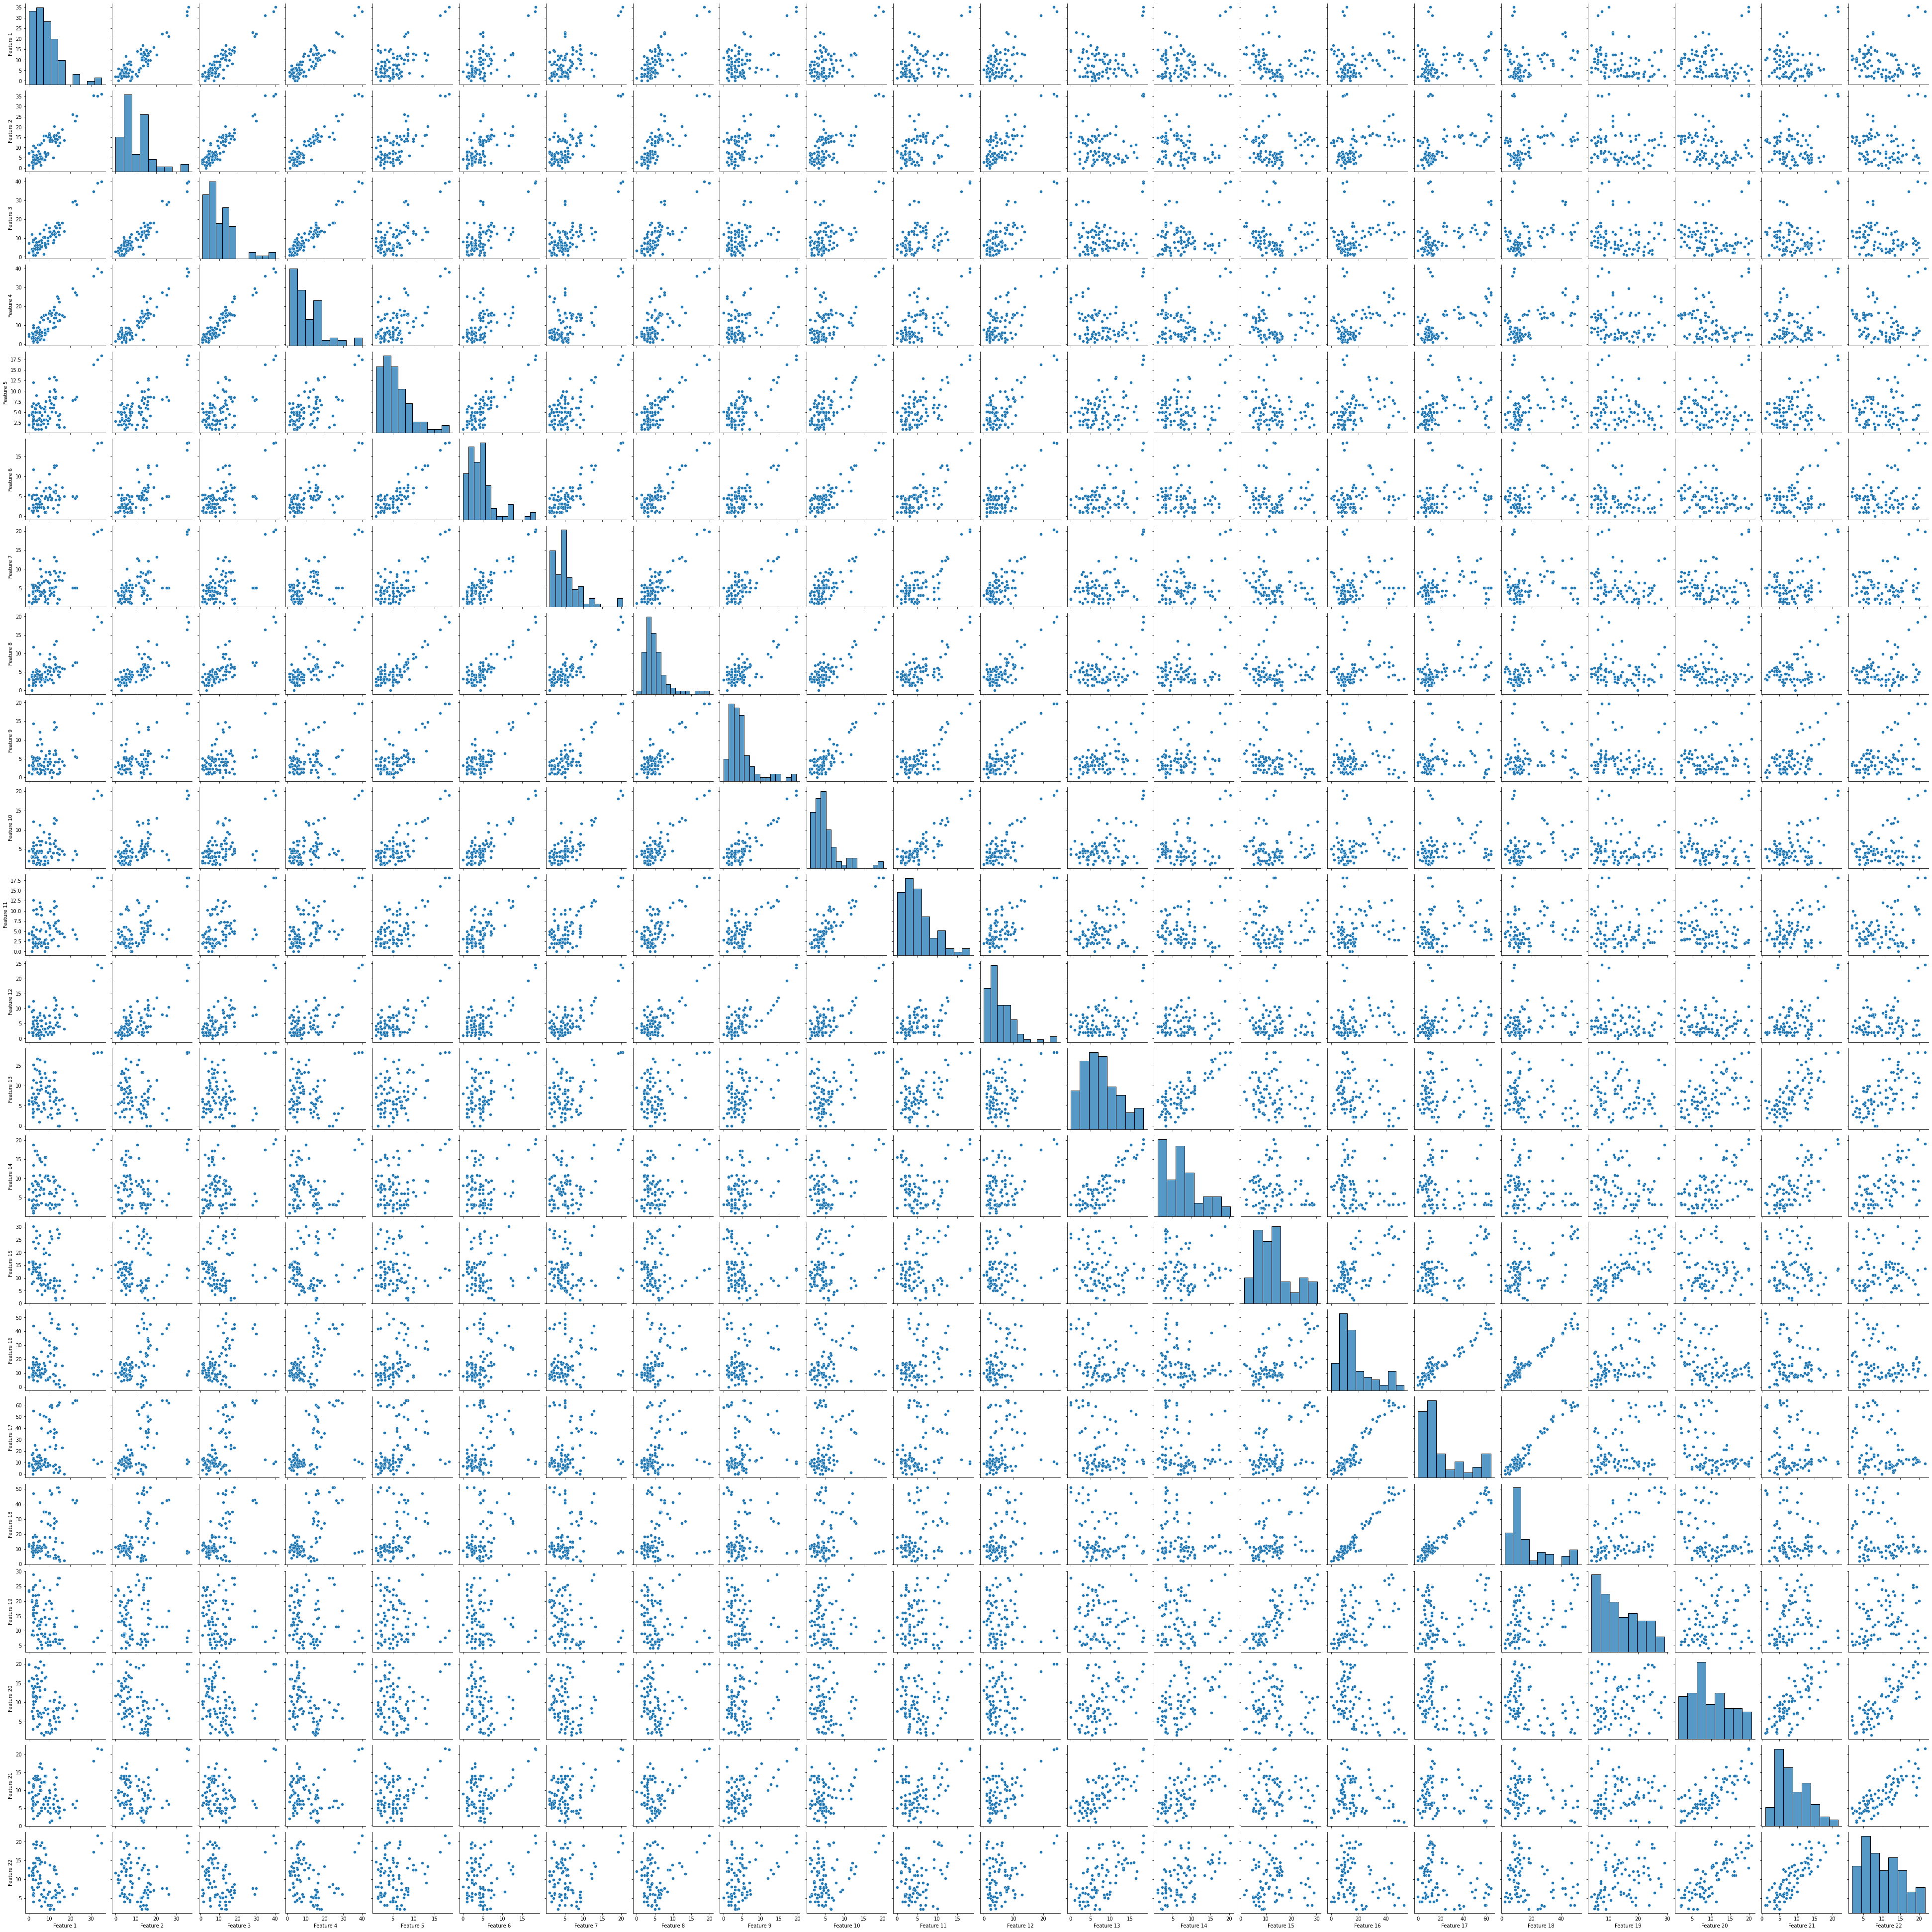

In [38]:
sns.pairplot(features)
plt.show()

In [39]:
corr_df = features.corr()
corr_df

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22
Feature 1,1.000000,0.897871,0.921366,0.905546,0.601923,0.653936,0.622302,0.737348,0.520974,0.563732,...,0.171722,0.174548,-0.176089,0.195285,0.297206,0.208248,-0.326170,-0.023141,0.149949,-0.032590
Feature 2,0.897871,1.000000,0.921674,0.921103,0.707769,0.744763,0.695592,0.816768,0.602932,0.667521,...,0.129434,0.099814,0.004338,0.397623,0.477435,0.395599,-0.140204,-0.071010,0.157395,-0.021898
Feature 3,0.921366,0.921674,1.000000,0.936998,0.644411,0.667441,0.627609,0.761738,0.567498,0.589104,...,0.165562,0.171682,-0.031608,0.344519,0.440419,0.362528,-0.157842,-0.020694,0.181408,-0.009485
Feature 4,0.905546,0.921103,0.936998,1.000000,0.624231,0.676183,0.591723,0.728976,0.510380,0.602570,...,0.073199,0.046064,0.052802,0.449224,0.536127,0.466239,-0.101478,-0.118880,0.105283,-0.088863
Feature 5,0.601923,0.707769,0.644411,0.624231,1.000000,0.836420,0.687315,0.810716,0.736964,0.770936,...,0.449032,0.288447,-0.048153,0.217327,0.258105,0.175832,-0.120290,0.066930,0.370289,0.226046
Feature 6,0.653936,0.744763,0.667441,0.676183,0.836420,1.000000,0.843169,0.867410,0.806232,0.848781,...,0.471352,0.292557,-0.001281,0.200499,0.247884,0.177897,-0.128343,0.060935,0.414483,0.229794
Feature 7,0.622302,0.695592,0.627609,0.591723,0.687315,0.843169,1.000000,0.825590,0.841115,0.832435,...,0.432220,0.378880,-0.084924,0.077282,0.134429,0.068511,-0.234049,0.119870,0.426171,0.235232
Feature 8,0.737348,0.816768,0.761738,0.728976,0.810716,0.867410,0.825590,1.000000,0.817613,0.834166,...,0.406520,0.331128,-0.018481,0.195912,0.244416,0.182254,-0.143708,0.076842,0.399378,0.225448
Feature 9,0.520974,0.602932,0.567498,0.510380,0.736964,0.806232,0.841115,0.817613,1.000000,0.860148,...,0.539251,0.458483,-0.115791,0.052694,0.109456,0.053460,-0.173535,0.262383,0.584108,0.401882
Feature 10,0.563732,0.667521,0.589104,0.602570,0.770936,0.848781,0.832435,0.834166,0.860148,1.000000,...,0.460051,0.306718,0.033051,0.128805,0.164609,0.112371,-0.090958,0.119580,0.442259,0.289881


In [57]:
w, v = np.linalg.eig(corr_df)
sum_of_w = 0
for num in w:
    sum_of_w += 1/num

sum_of_w

335.3009639887996

Looking at the correlation matrix and the sum of 1/(eigen values of the correlation matrix), There is a huge colinearlity in the data.<br>
Normally it can be said there is colinearlity if the value of the eigen values of the correlation matrix are larger than  5 times of number of features<br>

In [58]:
feature_val = features.values
vif = []
for i in range(len(features.columns)):
    vif.append(variance_inflation_factor(feature_val,i))

td = {
    'features': features.columns,
    'vif' : vif   
}
vif_df = pd.DataFrame(td)
vif_df

,features,vif
0,Feature 1,38.389491
1,Feature 2,46.227939
2,Feature 3,46.000472
3,Feature 4,56.548390
4,Feature 5,17.172548
5,Feature 6,22.075617
6,Feature 7,18.991505
7,Feature 8,27.393082
8,Feature 9,21.662282
9,Feature 10,28.637589


Furthermore, the value of VIF value of each features are larger than 10. <br>
Normally VIF > 10 then,  it can be said there is colinearlity in the data.

## Step2: PreProcessing

For, dealing with colinearlity and the outlier, I altered the outliers to the mean value of each feature. Also, to handle the colinearlity I scaled the data to standard normal distribution.

In [69]:
load_dataset('./facial_expression_train_dataset.csv', preprocess=True)
features = data.loc[:, data.columns != "Class Label"]

In [70]:
feature_val = features.values
vif = []
for i in range(len(features.columns)):
    vif.append(variance_inflation_factor(feature_val,i))

td = {
    'features': features.columns,
    'vif' : vif   
}
vif_df = pd.DataFrame(td)
vif_df

,features,vif
0,Feature 1,9.724000
1,Feature 2,9.745693
2,Feature 3,3.786204
3,Feature 4,11.680354
4,Feature 5,2.170406
5,Feature 6,2.640333
6,Feature 7,2.487121
7,Feature 8,2.968176
8,Feature 9,2.550836
9,Feature 10,2.755464


Removing the outliers and scaling the data, the colinearlity is mostly removed.

## Step3: Data split, Training and testing

In [102]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=104)

In [103]:
dis = DiscriminentAnalysis()

To find the optimal value of $\alpha$ and $\beta$ I used the gridsearch method and using the method I additionaly added K-fold crossvalidation.<br>
I set the values of $\alpha$ 0.0 to 1.0 moving 0.1, and beta as well.

In [104]:
dis = DiscriminentAnalysis()
params = {
    'alpha': np.linspace(0.0, 1.0, num=11, endpoint=True),
    'beta': np.linspace(0.0, 1.0, num=11, endpoint=True)
}

In [105]:
grid = GridSearchRDA(dis, params)
grid.fit(x_train, y_train, cv=5)

alpha:0.0, beta:0.0, accuracy:0.7385, recall:0.7622, precision:0.7985 ,f1-score:0.7162
alpha:0.0, beta:0.1, accuracy:0.8769, recall:0.8767, precision:0.9003 ,f1-score:0.8553
alpha:0.0, beta:0.2, accuracy:0.8769, recall:0.8767, precision:0.9003 ,f1-score:0.8553
alpha:0.0, beta:0.3, accuracy:0.9077, recall:0.9011, precision:0.9214 ,f1-score:0.8848
alpha:0.0, beta:0.4, accuracy:0.9077, recall:0.9011, precision:0.9214 ,f1-score:0.8848
alpha:0.0, beta:0.5, accuracy:0.9077, recall:0.9011, precision:0.9214 ,f1-score:0.8848
alpha:0.0, beta:0.6, accuracy:0.8923, recall:0.8878, precision:0.9114 ,f1-score:0.8702
alpha:0.0, beta:0.7, accuracy:0.8923, recall:0.8878, precision:0.9114 ,f1-score:0.8702
alpha:0.0, beta:0.8, accuracy:0.8923, recall:0.8878, precision:0.9114 ,f1-score:0.8702
alpha:0.0, beta:0.9, accuracy:0.8923, recall:0.8878, precision:0.9114 ,f1-score:0.8702
alpha:0.0, beta:1.0, accuracy:0.8923, recall:0.8911, precision:0.9083 ,f1-score:0.8784
alpha:0.1, beta:0.0, accuracy:0.8769, recal

In [107]:
print('Best F1 score is',grid.best_score)
print("alpha:{0}, beta{1}".format(grid.alpha, grid.beta))

Best F1 score is 0.9684848484848484
alpha:0.2, beta0.6000000000000001


The best score of f1-score is 0.9684 and the optimal value $\alpha$ and $\beta$ is  0.2 and 0.6

In [109]:
pred = []
for testing in x_test:
    pred.append(grid.best_estimator.predict(testing))

f1_score(y_test, pred, average='macro')

1.0

The evaluation of the model using test set gets the point 1.0. I think this result is for because the data set is too small for testing.

---

---

## Step4: model Evaluation

load the data by **putting the directory** to the load_dataset function

In [110]:
# load_dataset(directory=, preprocess=True)

The data will be splited to x and y when the load_dataset function is executed. x is the data for the features and y is the label.<br>
By executing the funtion it can be evaluated

In [111]:
# test_eval(x, y)